In [7]:
import sys
sys.path.insert(0, '../pypkg')

In [8]:
import qubla as qbl
import qubla.sim as qbsim
import time
import matplotlib.pyplot as plt

In [9]:
mulsrc = '''
    n = %d;
    x = input(quword{n});
    y = input(quword{n});
    z = x * y;
    output(z);
'''
narr = list(range(4,17))

stat = {}
isfirst = True
for n in narr:
    print(n, 'x', n, 'bit multiplication')
    state = 'raw'
    prevtime = time.time()
    mulql = qbl.QuantumLogic()
    mulql.compileSource(mulsrc % n)
    tmpstat = mulql.getStat()
    if isfirst:    
        for k in tmpstat:
            stat[k] = {}
        stat['runTime'] = {}
        isfirst = False
    
    while state != 'end':
        if state == 'raw':
            nextstate = 'reduced'
        elif state == 'reduced':
            mulql.reduce()
            tmpstat = mulql.getStat()
            nextstate = 'joined'
        elif state == 'joined':
            mulql.joinSteps(maxinqb=10)
            mulql.reduce()
            tmpstat = mulql.getStat()
            nextstate = 'unitarized'
        elif state == 'unitarized':
            mulql.unitarize()
            tmpstat = mulql.getStat()
            nextstate = 'end'
        currtime = time.time()
        tmpstat['runTime'] = currtime - prevtime
        prevtime = currtime
        for k in tmpstat:
            if state not in stat[k]:
                stat[k][state] = []    
            stat[k][state].append((n, tmpstat[k] ))        
        state = nextstate

4 x 4 bit multiplication
5 x 5 bit multiplication
6 x 6 bit multiplication
7 x 7 bit multiplication
8 x 8 bit multiplication
9 x 9 bit multiplication
10 x 10 bit multiplication
11 x 11 bit multiplication
12 x 12 bit multiplication
13 x 13 bit multiplication
14 x 14 bit multiplication
15 x 15 bit multiplication
16 x 16 bit multiplication


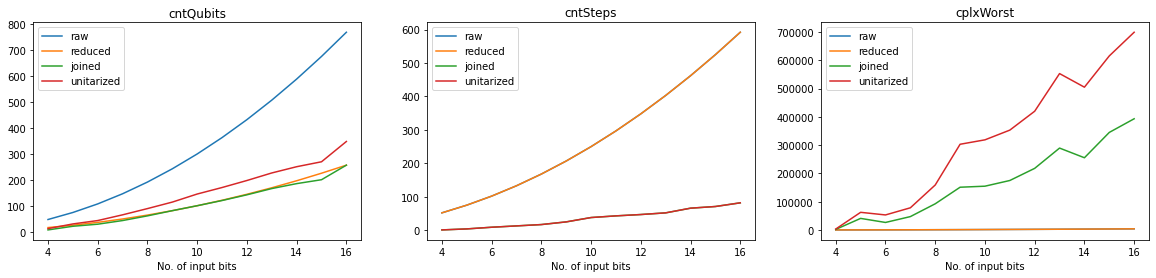

In [10]:

fig, axes = plt.subplots(1, 3)
fig.set_figwidth(20)
for idx, stattype in enumerate(['cntQubits', 'cntSteps', 'cplxWorst']):
    ax = axes[idx]
    ax.set_title(stattype)
    ax.set_xlabel('No. of input bits')
    for state in ['raw', 'reduced', 'joined','unitarized']:
        statdata = stat[stattype][state]
        ax.plot([statdata[i][0] for i in range(len(statdata))],
                 [statdata[i][1] for i in range(len(statdata))],
               label = state)
    ax.legend()
plt.show()

In [11]:
myql = qbl.QuantumLogic()

myql.compileSource('''  
    H = {0 : 1 / sqrt(2), 1 : 1 / sqrt(2)};
    n = 3;
    arrqbx = alloc(n);
    arrqby = alloc(n);
    for(i : seq(n)){
        arrqbx[i] = qstate(H)[0];
        arrqby[i] = qstate(H)[0];
    }
    x = uword{n}(arrqbx);
    y = uword{n}(arrqby);
    print("x: "+str(x));
    print("y: "+str(y));
    z = x*y;
    output(z);
    print("z: "+str(z));
''')

myql.reduce()
myql.joinSteps(maxinqb = 8)
myql.unitarize()
print()
print(myql)
print(myql.getStat())


x: [qbit[0], qbit[2], qbit[4]]
y: [qbit[1], qbit[3], qbit[5]]
z: [qbit[6], qbit[12], qbit[21], qbit[23], qbit[25], qbit[26]]

QuantumLogic:
Steps:
step[0] = qbinit([0], {[0] : 1/sqrt(2), [1] : 1/sqrt(2)})
step[1] = qbinit([1], {[0] : 1/sqrt(2), [1] : 1/sqrt(2)})
step[2] = qbinit([2], {[0] : 1/sqrt(2), [1] : 1/sqrt(2)})
step[3] = qbinit([3], {[0] : 1/sqrt(2), [1] : 1/sqrt(2)})
step[4] = qbinit([4], {[0] : 1/sqrt(2), [1] : 1/sqrt(2)})
step[5] = qbinit([5], {[0] : 1/sqrt(2), [1] : 1/sqrt(2)})
step[35] = applytbl(qbin=[0, 1, 3, 5, 2, 4], qbout=[3, 5, 0, 2, 1, 4, 6, 7, 8, 9], copyin=[False, False, False, False, False, False]
  [[0, 0, 0, 0, 0, 0] : [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
   [1, 0, 0, 0, 0, 0] : [0, 0, 0, 0, 0, 0, 1, 0, 0, 0],
   [0, 1, 0, 0, 0, 0] : [0, 0, 0, 0, 0, 0, 0, 1, 0, 0],
   [1, 1, 0, 0, 0, 0] : [1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
   [0, 0, 1, 0, 0, 0] : [0, 0, 0, 0, 0, 0, 1, 1, 0, 0],
   [1, 0, 1, 0, 0, 0] : [0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
   [0, 1, 1, 0, 0, 0] : [0, 0, 0, 0,

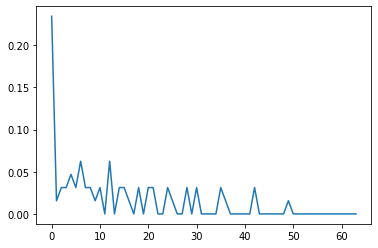

In [12]:
myql.comprQBits()
finalst = qbsim.statevec(myql)
stdens = qbsim.getDens(finalst, myql.getOutBits(0, True))
plt.plot(stdens)
